In [1]:
from aliases import *
import copy
from typing import Tuple
from senset import HLCA, PUC_ct, DE_test_ct, SncGeneSets
from senset.utils import construct_PU_results_table
from sklearn.decomposition import PCA, TruncatedSVD
from umap import UMAP
import grinch as gr
from itertools import combinations
from scipy.stats import ranksums
import textwrap
from senset.utils import pqvals
import seaborn.objects as so
from scipy.stats import pearsonr
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import LinearSegmentedColormap
import colorcet as cc

In [2]:
extension = "SNC-known-pca=10-prior=0.9-no-smoker"

In [3]:
pal = ['#465775', '#ef6f6c']
age_group_pal = ['#8338ec', '#ff006e', '#ffbe0b']
sex_colors = ['#439cfb', '#f1515e']
gs_overlap_colors = ['#f4f1de', '#e07a5f']

smoking_colors = {
    'N/A': '#ffffb3',
    'never': '#8dd3c7',
    'former': '#bebada',
    'active': '#fb8072',
}
senescence_colors = ['#8d99ae', '#c12f83']
senescence_colors_scatter = ['#9e0059', '#e0e1dd']
age_group_order = ['$\mathcal{Y}$', '$\mathcal{M}$', '$\mathcal{S}$']
cell_type_colors = sns.color_palette(cc.glasbey_light, n_colors=22)
pd.set_option('display.max_columns', None)

In [4]:
SNC = SncGeneSets(
    SenSet=f'dumps/SenSet-{extension}.txt',
    remove_downregulated=False,
)
gene_sets = SNC.gene_sets
print(SNC)

Gene Set module with keys:
	GO: 83
	Fridman: 90
	SenMayo: 125
	CellAge: 279
	union: 501
	SenSet: 106



In [5]:
with open(f"dumps/PU-{extension}.pkl", "rb") as f:
    PU = pickle.load(f)

In [6]:
hlca = HLCA('../SenSet/data/HLCA.h5ad', remove_smokers=True)
adata = hlca.adata

Removing 3427 cells with age='NaN'
Removing 279726 cells from smokers


In [7]:
age_group = np.where(hlca.age < 30, '$\mathcal{Y}$', '$\mathcal{M}$')
age_group[hlca.age >= 50] = '$\mathcal{A}$'
adata.obs['Age Group'] = age_group

  adata.obs['Age Group'] = age_group



In [8]:
adata = adata[:, np.in1d(adata.var['feature_name'], SNC.SenSet)]

## Table DF

In [9]:
table_df = pd.read_excel(f'dumps/Complete-{extension}.xlsx')

def get_col_items(col):
    items = table_df['Up']
    items = npu(npc(items[~pd.isna(items)].str.split(', ').tolist()))
    return items

def count_col_items(col):
    items = table_df[col]
    items = Counter(npc(items[~pd.isna(items)].str.split(', ').tolist()))
    return items

up_genes = get_col_items('Up')
down_genes = get_col_items('Down')
up_genes_count = count_col_items('Up')
down_genes_count = count_col_items('Down')
assert np.in1d(up_genes, SNC.SenSet).all()
assert np.in1d(down_genes, SNC.SenSet).all()

In [10]:
markers = []

def _process(row, column):
    if pd.isna(row[column]):
        return
    for gene_name, statistic in zip(row[column].split(', '), eval(row[f"{column} statistic"])):
        markers.append({
            "Cell_Type": row['Cell Type'],
            "Gene": gene_name,
            "Regulation": column,
            "Statistic": statistic,
            "abs(Statistic)": np.abs(statistic),
        })

for i, row in table_df.iterrows():
    _process(row, 'Up')
    _process(row, 'Down')

markers_df = pd.DataFrame(markers)

In [11]:
# top_genes = [v for v in Counter(markers_df['Gene']).most_common() if v[1] >= 10]
top_genes = SNC.SenSet

In [12]:
CT_to_consider = npu(markers_df['Cell_Type'])
CT_to_indexed = {ct: f"{i + 1}. {ct}" for i, ct in enumerate(CT_to_consider)}
ct_column = [CT_to_indexed[ct] for ct in markers_df['Cell_Type']]
markers_df['Cell Type'] = ct_column

### Overlap of marker lists

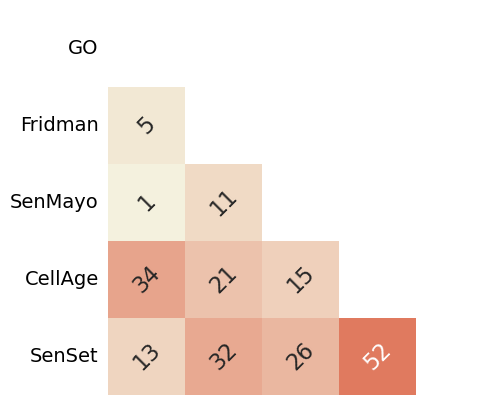

In [98]:
N = len(SNC.gene_sets)
fig, ax = plt.subplots(figsize=(5, 5))

mask = np.zeros((N, N), dtype=bool)
mask[np.triu_indices_from(mask)] = True
data = [getattr(SNC, gene_set) for gene_set in SNC.gene_sets]

N = len(data)
hm = np.zeros((N, N), dtype=int) - 1
for i in range(N):
    for j in range(i, N):
        hm[i, j] = hm[j, i] = np.intersect1d(data[i], data[j]).size

sns.heatmap(
    hm,
    annot=True,
    fmt='.3g',
    xticklabels=gene_sets,
    yticklabels=gene_sets,
    annot_kws={'size': 16, 'rotation': 45},
    ax=ax,
    square=True,
    cbar=False,
    mask=mask,
    cmap=LinearSegmentedColormap.from_list("custom_cmap", gs_overlap_colors),
)
colony.correct_font_size(ax)
ax.tick_params(bottom=False, labelbottom=False, left=False)
ax.tick_params(axis='y', rotation=0)

# artist.savefig('figures/SenSet/overlaps-tri.pdf')
plt.show()

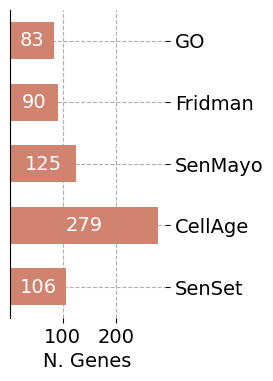

In [116]:
fig, ax = plt.subplots(figsize=(2, 4))
sns.barplot(
    x=[getattr(SNC, set).size for set in gene_sets],
    y=gene_sets,
    color=gs_overlap_colors[1],
    width=0.6,
    ax=ax,
)
sns.despine(ax=ax, bottom=True)
colony.correct_font_size(ax)
ax.set_xticks([100, 200])
ax.yaxis.tick_right()
ax.grid(zorder=-1, linestyle='--')
ax.set_axisbelow(True)
ax.set_xlabel('N. Genes')
ax.bar_label(ax.containers[0], label_type='center', color='white', fontsize=14)

artist.savefig('figures/SenSet/sets-size.pdf')
plt.show()

### SenSet markers jointplot

  ax3.set_yticklabels((_dd['Snc. Prop. >50'] * 100).map('{:,.2g}%'.format))



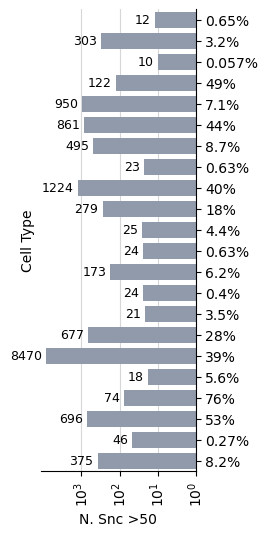

In [182]:
fig, ax3 = plt.subplots(figsize=(2, 6))

_dd = table_df[(table_df['N. Snc >50'] >= 10) & (table_df['Cell Type'] != 'stromal cell')]

sns.barplot(
    _dd,
    x='N. Snc >50',
    y='Cell Type',
    # hue='Prop. Snc >50',
    ax=ax3,
    color='#8d99ae',
)

sns.despine(ax=ax3, right=False, left=True)
ax3.tick_params(axis='x', rotation=90)
ax3.set_xscale('log')
ax3.set_xticks([1, 10, 100, 1000])

# for i in range(1, 1001, 100):
#     ax3.axvline(x=i, color='gray', alpha=0.5, zorder=-1, linestyle='--', linewidth=0.7)
# ax3.axhline(y=10, color='gray', alpha=0.5, zorder=-1)
ax3.invert_xaxis()
ax3.grid(axis='x', alpha=0.5)
ax3.yaxis.tick_right()
ax3.bar_label(ax3.containers[0], fontsize=9, padding=3)
ax3.set_axisbelow(True)

ax3.set_yticklabels((_dd['Snc. Prop. >50'] * 100).map('{:,.2g}%'.format))

artist.savefig('figures/SenSet/PUc-SNC.pdf')
plt.show()

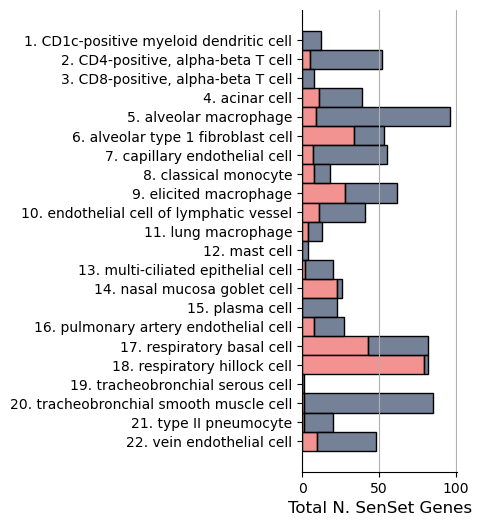

In [176]:
fig, ax = plt.subplots(figsize=(2, 6))

sns.histplot(
    markers_df,
    y='Cell Type',
    multiple='stack',
    palette=['#465775', '#ef6f6c'],
    hue='Regulation',
    ax=ax,
)

sns.despine(ax=ax)
ax.set_ylabel('')
ax.set_xlabel('N. genes')
ax.grid(axis='x')
ax.set_xlabel('Total N. SenSet Genes', fontsize=12)
ax.legend().remove()
# colony.correct_font_size(ax)

artist.savefig('figures/SenSet/CT-total-counts.pdf')
plt.show()

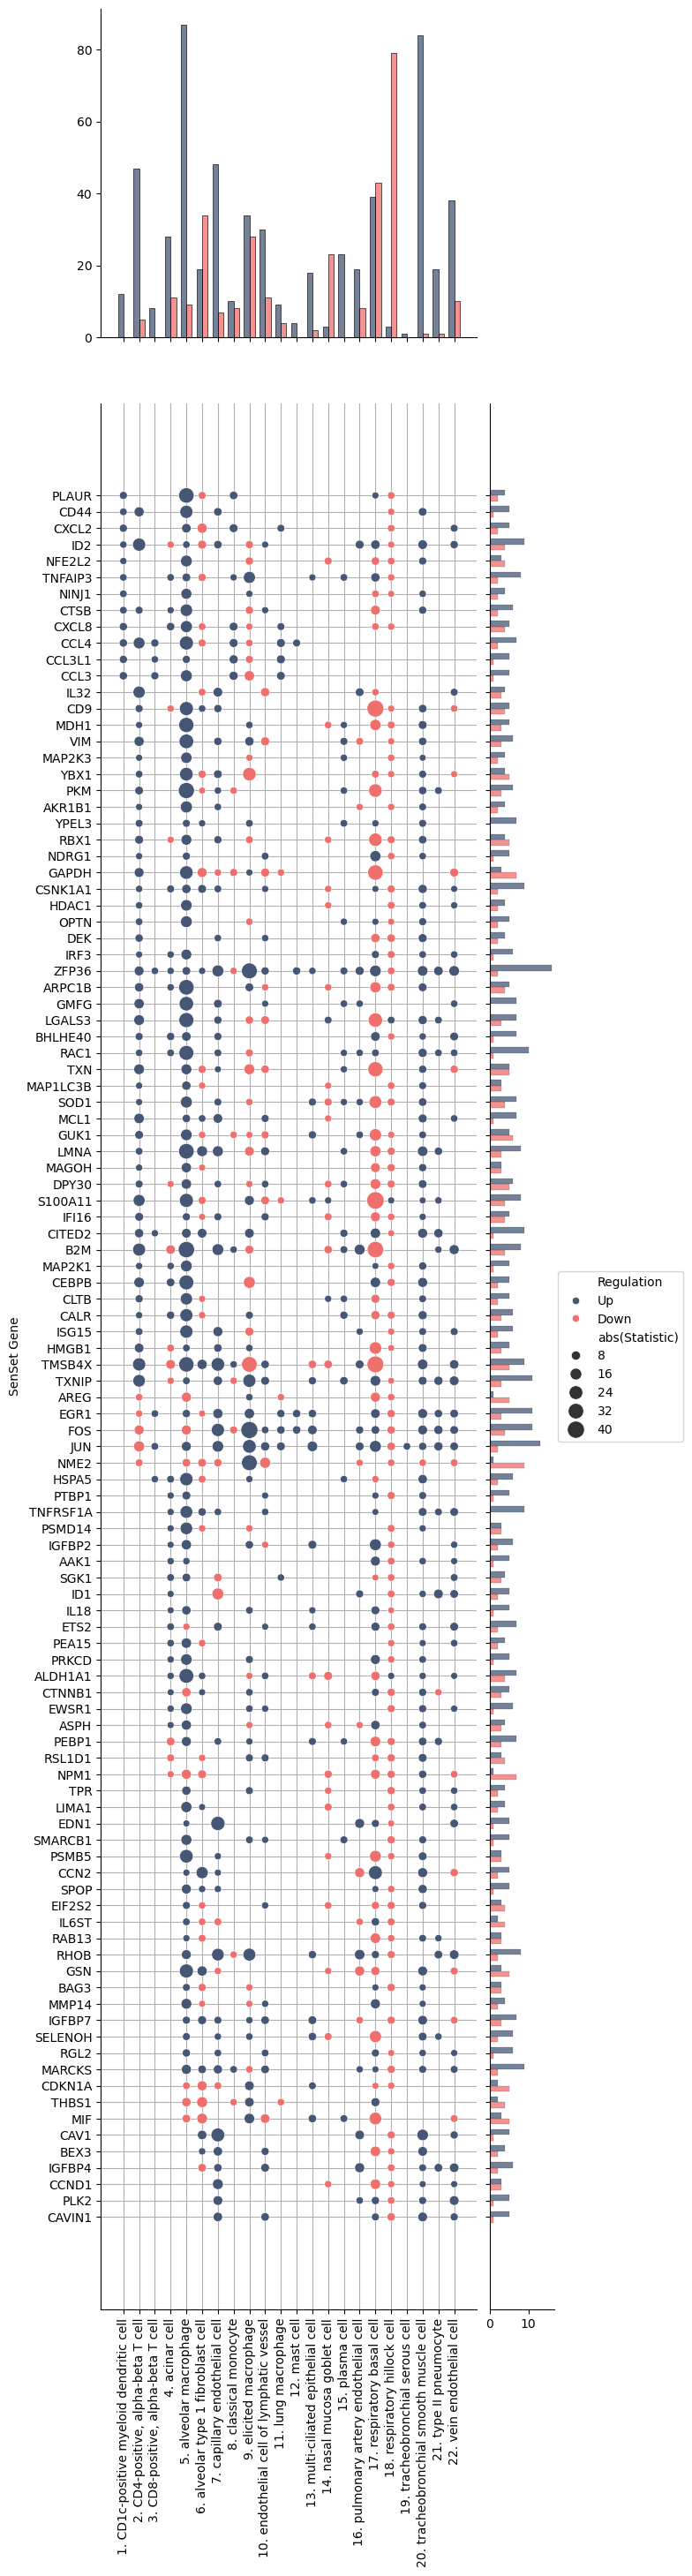

In [17]:
sub_df = markers_df[np.in1d(markers_df['Gene'], top_genes)]

g = sns.JointGrid(
    data=sub_df,
    x="Cell Type",
    y="Gene",
    hue="Regulation",
    hue_order=['Up', 'Down'],
    palette=['#465775', '#ef6f6c'],
    marginal_ticks=True,
)
g.plot_joint(
    sns.scatterplot,
    data=sub_df,
    size='abs(Statistic)',
    sizes=(30, 200)
)
g.plot_marginals(sns.histplot, multiple="dodge", shrink=.7)
g.figure.set_size_inches((6, 30))
ax = g.figure.axes[0]
ax.tick_params(axis='x', rotation=90)
ax.grid(zorder=-1)
ax.set_xlabel('')
ax.set_axisbelow(True)
ax.set_ylabel('SenSet Gene')
sns.move_legend(ax, "center left", bbox_to_anchor=(1.2, 0.5))

artist.savefig('figures/SenSet/markers-jointplot-complete.pdf')
plt.show()

### Bar Plots of Markers

In [67]:
gene_exp = []

def get_ct_gene(cell_type, gene):
    data = PU[cell_type]
    if data is None:
        return None
    argidx = data['argidx']
    ad = adata[argidx, adata.var['feature_name'] == gene]
    ad = ad[data['y'] == 2]
    snc = ad.X[data['u_te_x_pred'] == -1]
    healthy = ad.X[data['u_te_x_pred'] == 1]
    if snc.shape[0] < 20 or healthy.shape[0] < 20:
        return None

    healthy, snc = healthy.toarray().ravel(), snc.toarray().ravel()
    cell_status = ['Healthy'] * len(healthy) + ['Senescent'] * len(snc)
    return pd.DataFrame({'Cell State': cell_status,
                         'Expression': npc([healthy, snc]),
                         'Cell Type': cell_type,
                         'Gene': gene})

In [68]:
dfs = []

for cell_type in tqdm(PU):
    for gene in top_genes:
        exp_df = get_ct_gene(cell_type, gene[0])
        if exp_df is not None:
            dfs.append(exp_df)
exp_df = pd.concat(dfs)

  0%|          | 0/50 [00:00<?, ?it/s]

In [69]:
unq_cell_types = npu(exp_df['Cell Type'])

In [128]:
best_df = []
ct_to_best_gene = {}
gene_used = ['GAPDH']

for cell_type in unq_cell_types:
    _df = exp_df[exp_df['Cell Type'] == cell_type]
    lowest_p, lowest_gene = 1, None
    for gene, gene_df in _df.groupby('Gene'):
        x_healthy = gene_df[gene_df['Cell State'] == 'Healthy']['Expression'].to_numpy()
        x_snc = gene_df[gene_df['Cell State'] == 'Senescent']['Expression'].to_numpy()
        out = ranksums(x_snc, x_healthy)
        if lowest_p > out.pvalue and gene not in gene_used:
            lowest_p = out.pvalue
            lowest_gene = gene
    temp_df = _df[_df['Gene'] == lowest_gene].copy()
    temp_df['P'] = lowest_p
    best_df.append(temp_df)
    ct_to_best_gene[cell_type] = (lowest_gene, lowest_p)
    gene_used.append(lowest_gene)
best_df = pd.concat(best_df, ignore_index=True)

In [129]:
to_remove = ['acinar cell', 'endothelial cell of lymphatic vessel', 'vein endothelial cell', 'CD4-positive, alpha-beta T cell', 'nasal mucosa goblet cell', 'tracheobronchial serous cell', 'classical monocyte']
assert np.in1d(to_remove, unq_cell_types).all()

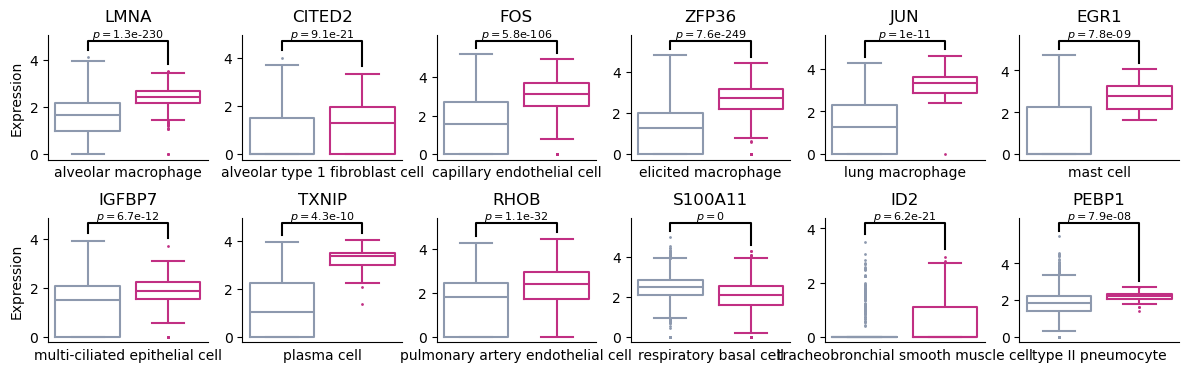

In [171]:
usable_df = best_df[~np.in1d(best_df['Cell Type'], to_remove)]

g = sns.catplot(
    usable_df,
    x='Cell State',
    y='Expression',
    col='Cell Type',
    col_wrap=6,
    kind='box',
    hue='Cell State',
    palette=senescence_colors,
    sharex=False,
    sharey=False,
    height=2,
    fliersize=1,
    fill=False,
    facet_kws={},
)

g.set_titles("{col_name}")
for ax in g.axes.flat:
    # colony.correct_font_size(ax)
    cell_type = ax.get_title()
    ax.set_title(ct_to_best_gene[cell_type][0], pad=10)
    ax.set_xlabel(cell_type)
    ax.tick_params(bottom=False, labelbottom=False)
    ax.set_yticks([0, 2, 4])
    mh = usable_df[(usable_df['Cell Type'] == cell_type) & (usable_df['Cell State'] == 'Healthy')]['Expression'].max()
    ms = usable_df[(usable_df['Cell Type'] == cell_type) & (usable_df['Cell State'] == 'Senescent')]['Expression'].max()
    ax.plot([0, 0, 1, 1], [mh + 0.3, max(ms, mh) + 0.7, max(ms, mh) + 0.7, ms + 0.3], color='black')
    ax.text(0.5, max(ms, mh) + 0.7, f"$p=${ct_to_best_gene[cell_type][1]:.2g}", va='bottom', ha='center', fontsize=8)

artist.savefig('figures/SenSet/boxplots.pdf')
plt.show()

### Scatter Plots

In [24]:
cell_type_index = [CT_to_indexed[ct].split('.')[0] if ct in CT_to_indexed else '' for ct in adata.obs['cell_type']]

In [25]:
adata.obs['Cell Type i'] = cell_type_index

In [42]:
is_old = adata.obs['age_or_mean_of_age_range'] >= 50
is_noti = adata.obs['Cell Type i'] != ''

In [43]:
scatter = ps.Scatter(
    adata[is_old & is_noti].obsm['X_umap'],
    idx=adata[is_old & is_noti].obs['Cell Type i'].to_numpy(),
)

  return bound(*args, **kwds)



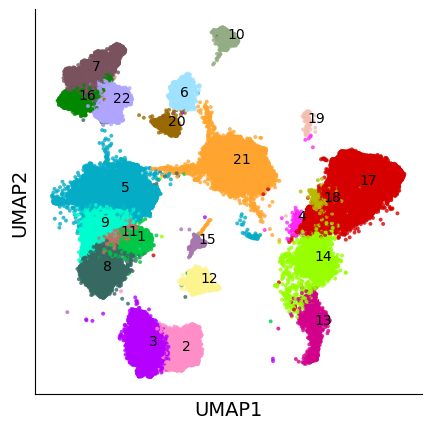

In [74]:
fig, ax = plt.subplots(figsize=(5, 5))

ps.scatterplot(
    scatter,
    hue='idx',
    palette=cell_type_colors,
    add_centroids=True,
    ax=ax,
)
sns.despine(ax=ax)
ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
ax.legend().remove()
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
colony.correct_font_size(ax)

points = fig.axes[0].collections[0]
points.set_rasterized(True)

artist.savefig('figures/SenSet/UMAP-cell_types.pdf')
plt.show()

### Scatter senescent cells

In [89]:
is_snc = np.zeros(adata.shape[0]).astype(bool)
for cell_type, data in PU.items():
    if data is None:
        continue
    ad = adata[data['argidx']]
    is_snc[data['argidx'][data['y'] == 0][data['p_x_pred'] == -1]] = True
    is_snc[data['argidx'][data['y'] == 1][data['u_tr_x_pred'] == -1]] = True
    is_snc[data['argidx'][data['y'] == 2][data['u_te_x_pred'] == -1]] = True

In [113]:
scatter = ps.Scatter(
    adata[is_old & is_noti].obsm['X_umap'],
    idx=pd.Categorical(np.where(is_snc[is_old & is_noti], 'Senescent', 'Healthy'), categories=['Senescent', 'Healthy']),
)

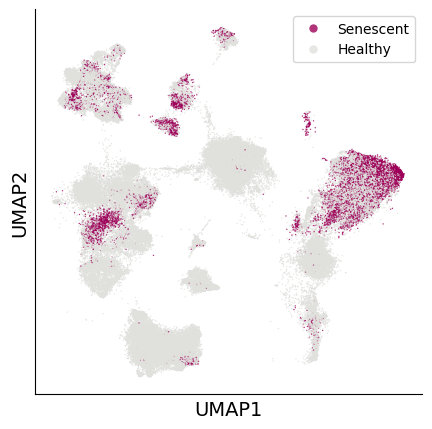

In [117]:
fig, ax = plt.subplots(figsize=(5, 5))

ps.scatterplot(
    scatter,
    hue='idx',
    palette=senescence_colors_scatter,
    s=1,
    linewidth=0,
    alpha=0.8,
    ax=ax,
    rasterized=True,
)
sns.despine(ax=ax)
ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
ax.legend().remove()
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
colony.correct_font_size(ax)

points = fig.axes[0].collections[0]
points.set_rasterized(True)
ax.legend(markerscale=6)

artist.savefig('figures/SenSet/UMAP-SnCs.pdf')
plt.show()

### GSEA

In [5]:
import gseapy as gp
from gseapy import barplot, dotplot

enr = gp.enrich(
    gene_list=SNC.SenSet.tolist(),
    gene_sets=['GO_Biological_Process_2023',
               'MSigDB_Hallmark_2020',
               'Jensen_DISEASES'],
    outdir=None,
)

In [ ]:
df = enr.results
df[enr.results['Gene_set'] == 'GO_Biological_Process_2023']

In [8]:
[v for v in gp.get_library_name() if 'Jensen' in v]

['Jensen_COMPARTMENTS', 'Jensen_DISEASES', 'Jensen_TISSUES']

  df[self.colname].replace(

The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(



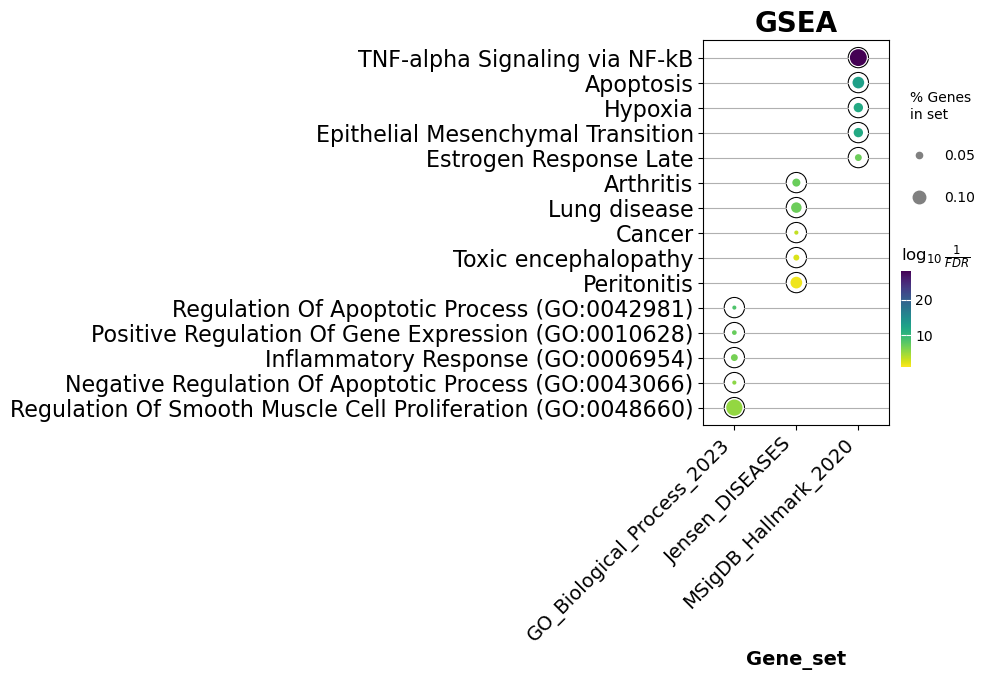

In [133]:
ax = dotplot(
    enr.results,
    column="Adjusted P-value",
    x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
    size=15,
    top_term=5,
    figsize=(3,5),
    title = "GSEA",
    xticklabels_rot=45, # rotate xtick labels
    show_ring=True, # set to False to revmove outer ring
    marker='o',
)

artist.savefig('figures/SenSet/GSEA.pdf')
plt.show()

# Divergences between smokers

In [6]:
!export CPATH=$CPATH:/usr/local/cuda/include
!export LIBRARY_PATH=$LIBRARY_PATH:/usr/local/cuda/lib64
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/cuda/lib64

In [7]:
from geomloss import SamplesLoss
import torch

In [8]:
Loss =  SamplesLoss("sinkhorn", blur=0.01)

In [9]:
hlca = HLCA('../SenSet/data/HLCA.h5ad', remove_smokers=False)
adata = hlca.adata

Removing 3427 cells with age='NaN'


In [10]:
# adata = adata[:, np.in1d(adata.var['feature_name'], SNC.SenSet)]

In [11]:
age_group = np.where(hlca.age < 30, '$\mathcal{Y}$', '$\mathcal{M}$')
age_group[hlca.age >= 50] = '$\mathcal{S}$'
age_groups = npu(age_group)
adata.obs['Age Group'] = age_group

  adata.obs['Age Group'] = age_group



In [13]:
def compute_div(cell_type):
    ad = adata[adata.obs['cell_type'] == cell_type]
    xy_nons = ad[(ad.obs['Age Group'] == '$\mathcal{Y}$') & (ad.obs['smoking_status'] == 'never')]
    xy_s = ad[(ad.obs['Age Group'] == '$\mathcal{Y}$') & (ad.obs['smoking_status'] == 'active')]
    xs_nons = ad[(ad.obs['Age Group'] == '$\mathcal{S}$') & (ad.obs['smoking_status'] == 'never')]
    xs_s = ad[(ad.obs['Age Group'] == '$\mathcal{S}$') & (ad.obs['smoking_status'] == 'active')]

    K = 5000
    if xy_nons.shape[0] >= K:
        xy_nons = xy_nons[np.random.choice(xy_nons.shape[0], K - 1, replace=False)]
    if xy_s.shape[0] >= K:
        xy_s = xy_s[np.random.choice(xy_s.shape[0], K -1 , replace=False)]
    if xs_nons.shape[0] >= K:
        xs_nons = xs_nons[np.random.choice(xs_nons.shape[0], K - 1, replace=False)]
    if xs_s.shape[0] >= K:
        xs_s = xs_s[np.random.choice(xs_s.shape[0], K - 1, replace=False)]

    xy_kl, xs_kl, xmix_kl, xmix_s_kl = None, None, None, None

    func = Loss
    cv = torch.from_numpy

    if xy_nons.shape[0] >= 20 and xy_s.shape[0] >= 20:
        xy_kl = func(cv(xy_nons.X.toarray()), cv(xy_s.X.toarray())).item()
    if xs_nons.shape[0] >= 20 and xs_s.shape[0] >= 20:
        xs_kl = func(cv(xs_nons.X.toarray()), cv(xs_s.X.toarray())).item()
    if xy_s.shape[0] >= 20 and xs_nons.shape[0] >= 20:
        xmix_kl = func(cv(xy_s.X.toarray()), cv(xs_nons.X.toarray())).item()
    if xy_s.shape[0] >= 20 and xs_s.shape[0] >= 20:
        xmix_s_kl = func(cv(xy_s.X.toarray()), cv(xs_s.X.toarray())).item()

    return {
        "Cell Type": cell_type,
        "W(Young Non-Smoker, vs Young Smoker)": xy_kl,
        "W(Young Smoker, vs Old Non-Smoker)": xmix_kl,
        "W(Young Smoker, vs Old Smoker)": xmix_s_kl,
        "W(Old Non-Smoker, vs Old Smoker)": xs_kl,
    }

In [19]:
wlist = []

for cell_type in tqdm(CT_to_consider):
    wlist.append(compute_div(cell_type))

  0%|          | 0/22 [00:00<?, ?it/s]

In [98]:
wdf = pd.DataFrame(wlist)
idx = [CT_to_indexed[ct].split('.')[0] for ct in wdf['Cell Type']]
wdf.index = idx
wdf.drop('Cell Type', axis=1, inplace=True)
wdf['W(Young Smoker, vs Young Non-Smoker)'] = wdf['W(Young Non-Smoker, vs Young Smoker)']
wdf.drop('W(Young Non-Smoker, vs Young Smoker)', axis=1, inplace=True)
# wdf.dropna(inplace=True)

In [99]:
ff = wdf['W(Young Smoker, vs Old Non-Smoker)'].to_numpy() / wdf['W(Young Smoker, vs Young Non-Smoker)'].to_numpy()
idx = ff.argsort()

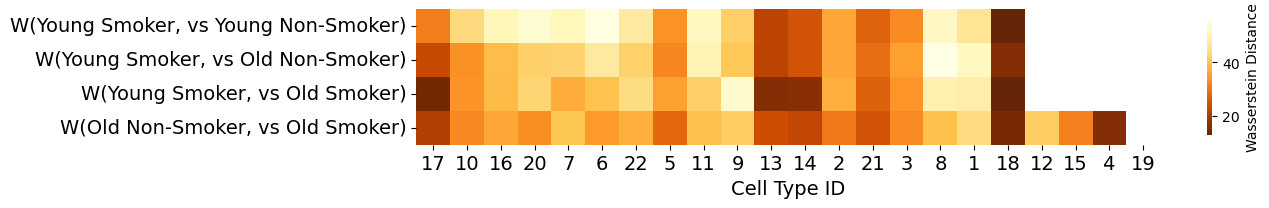

In [121]:
fig, ax = plt.subplots(figsize=(12, 5))

sns.heatmap(
    wdf.iloc[:, [3, 0, 1, 2]].iloc[idx].T,
    square=True,
    cbar_kws={'shrink': 0.3, 'label': 'Wasserstein Distance'},
    cmap=sns.color_palette("YlOrBr_r", as_cmap=True),
    ax=ax,
)

ax.set_xlabel('Cell Type ID')
colony.correct_font_size(ax)

# artist.savefig('figures/SenSet/wasserstein.pdf')
plt.show()